In [27]:
#all imports
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.models import Model
from tqdm import trange 



from tensorflow.keras import layers
from transformers import BertTokenizer, BertModel
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import plotly.express as px
import seaborn as sns
import string
import string
from nltk.corpus import stopwords
from nltk import PorterStemmer as Stemmer

from sklearn.metrics import f1_score

from sklearn.linear_model import LogisticRegression
import random
from sklearn.preprocessing import LabelEncoder

In [7]:
df = pd.read_csv("/content/drive/MyDrive/spam or ham/preprocessed_data.csv")
df.head()

,Unnamed: 0,target,clean_text
0,0,ham,go jurong point crazi avail bugi n great world...
1,1,ham,ok lar joke wif u oni
2,2,spam,free entri 2 wkli comp win fa cup final tkt 21...
3,3,ham,u dun say earli hor u c alreadi say
4,4,ham,nah dont think goe usf live around though


In [66]:
df.shape

(5572, 2)

In [8]:
df.drop(["Unnamed: 0"],axis=1,inplace=True)

In [9]:
#split the data into train and test data(20%) with Stratify sampling, random state 33, 
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df["clean_text"], df["target"], test_size=0.20, random_state=33)

In [10]:
## Loading the Pretrained Model from tensorflow HUB
tf.keras.backend.clear_session()

# maximum length of a seq in the data we have, for now i am making it as 55. You can change this
max_seq_length = 200

#BERT takes 3 inputs

#this is input words. Sequence of words represented as integers
input_word_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="input_word_ids")

#mask vector if you are padding anything
input_mask = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="input_mask")

#segment vectors. If you are giving only one sentence for the classification, total seg vector is 0. 
#If you are giving two sentenced with [sep] token separated, first seq segment vectors are zeros and 
#second seq segment vector are 1's
segment_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="segment_ids")

#bert layer 
bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1", trainable=False)
pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])

#Bert model
#We are using only pooled output not sequence out. 
#If you want to know about those, please read https://www.kaggle.com/questions-and-answers/86510
bert_model = Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=pooled_output)


INFO:absl:Using /tmp/tfhub_modules to cache modules.
INFO:absl:Downloading TF-Hub Module 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1'.
INFO:absl:Downloaded https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1, Total size: 423.26MB
INFO:absl:Downloaded TF-Hub Module 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1'.


In [11]:
bert_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 200)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 200)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 200)]        0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        [(None, 768), (None, 109482241   input_word_ids[0][0]             
                                                                 input_mask[0][0]             

In [13]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [14]:
tokenizer.tokenize("hello world")

['hello', 'world']

In [15]:
X_Train = []
for i in range(len(X_train)):
    X_Train.append(X_train.values[i])
X_Test = []
for i in range(len(X_test)):
    X_Test.append(X_test.values[i])


In [18]:
X_train_tokens = []
X_train_mask = []
X_train_segment = []
for line in X_Train:
    tok = tokenizer.tokenize(str(line))
    if(len(tok) > max_seq_length-2):
        
        tok = tok[:(max_seq_length-2)]
    tokens = ['[CLS]',*tok,'[SEP]']
    seg_list = [0]*max_seq_length
    pos_encoding = tokenizer.convert_tokens_to_ids(tokens)
    mask_list = [1]*len(pos_encoding)
    while(len(pos_encoding) < max_seq_length):
        
        pos_encoding.append(0)
        mask_list.append(0)
    X_train_tokens.append(pos_encoding)
    X_train_mask.append(mask_list)
    X_train_segment.append(seg_list)

In [19]:
X_train_tokens = np.array(X_train_tokens)
X_train_mask = np.array(X_train_mask)
X_train_segment = np.array(X_train_segment)

print("checking shapes")
print(X_train_tokens.shape)
print(X_train_mask.shape)
print(X_train_segment.shape)

checking shapes
(4457, 200)
(4457, 200)
(4457, 200)


In [20]:
X_test_tokens = []
X_test_mask = []
X_test_segment = []
for line in X_Test:
    
    tok = tokenizer.tokenize(str(line))
    if(len(tok) > max_seq_length-2):
        
        tok = tok[:(max_seq_length-2)]
    tokens = ['[CLS]',*tok,'[SEP]']
    seg_list = [0]*max_seq_length
    pos_encoding = tokenizer.convert_tokens_to_ids(tokens)
    mask_list = [1]*len(pos_encoding)
    while(len(pos_encoding) < max_seq_length):
        pos_encoding.append(0)
        mask_list.append(0)
    X_test_tokens.append(pos_encoding)
    X_test_mask.append(mask_list)
    X_test_segment.append(seg_list)

In [21]:
X_test_tokens = np.array(X_test_tokens)
X_test_mask = np.array(X_test_mask)
X_test_segment = np.array(X_test_segment)
print("checking shapes")
print(X_test_tokens.shape)
print(X_test_mask.shape)
print(X_test_segment.shape)

checking shapes
(1115, 200)
(1115, 200)
(1115, 200)


In [22]:
bert_model.input

[<KerasTensor: shape=(None, 200) dtype=int32 (created by layer 'input_word_ids')>,
 <KerasTensor: shape=(None, 200) dtype=int32 (created by layer 'input_mask')>,
 <KerasTensor: shape=(None, 200) dtype=int32 (created by layer 'segment_ids')>]

In [23]:
bert_model.output

<KerasTensor: shape=(None, 768) dtype=float32 (created by layer 'keras_layer')>

In [24]:
%%time
# get the train output, BERT model will give one output so save in
# X_train_pooled_output
X_train_pooled_output=bert_model.predict([X_train_tokens,X_train_mask,X_train_segment])
X_test_pooled_output=bert_model.predict([X_test_tokens,X_test_mask,X_test_segment])

CPU times: user 18.6 s, sys: 4.04 s, total: 22.6 s
Wall time: 2min 37s


In [28]:
le=LabelEncoder()
le.fit(y_train.values)

LabelEncoder()

In [29]:
y_Train = le.transform(y_train.values)
y_Test= le.transform(y_test.values)

In [57]:
Y_Train = tf.keras.utils.to_categorical(
    y_Train, num_classes=None, dtype='float32'
)


In [58]:
Y_Test = tf.keras.utils.to_categorical(
    y_Test, num_classes=None, dtype='float32'
)


In [59]:
##imports
from tensorflow.keras.layers import Input, Dense, Activation, Dropout
from tensorflow.keras.models import Model

In [60]:
# for saving model , stoping early and chaning learning rate
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import ReduceLROnPlateau
import datetime
import warnings 
warnings.filterwarnings('ignore')
from sklearn.metrics import f1_score,roc_auc_score

In [61]:
X_train_pooled_output.shape
# print(y_train.shape)

(4457, 768)

In [62]:
input_layer = Input(shape=(768,))
x = Dense(384)(input_layer)
x = Dense(192)(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = Dense(128)(x)
x = Dense(64)(x)
x = Dense(32)(x)
x = Dense(16)(x)
output = Dense(1,activation="sigmoid")(x)
model_f = Model(inputs = input_layer,outputs = output)

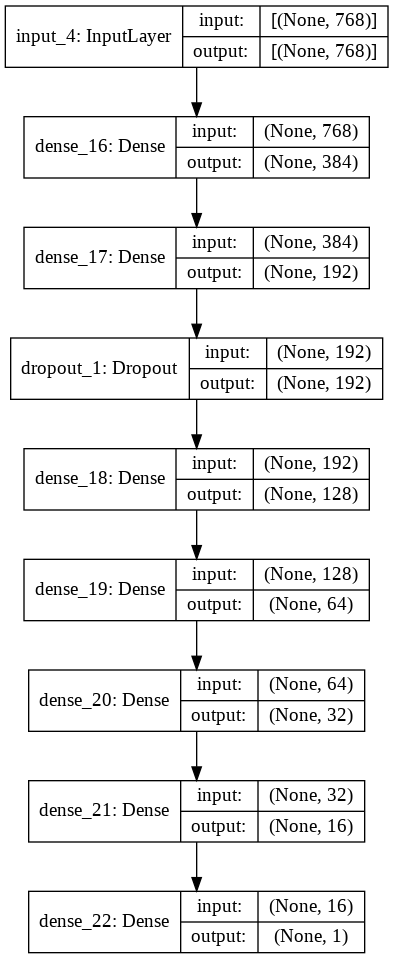

In [63]:
from keras.utils.vis_utils import plot_model
plot_model(model_f, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [64]:
# https://keras.io/api/callbacks/
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5),
    tf.keras.callbacks.ModelCheckpoint(filepath='model.{epoch:02d}-{val_loss:.2f}.h5',save_best_only=True),
    tf.keras.callbacks.TensorBoard(log_dir='./logs'),
]

In [65]:
model_f.compile(loss = "categorical_crossentropy", optimizer = "Adam",metrics=["accuracy"])

In [67]:
history = model_f.fit(X_train_pooled_output,y_Train,batch_size=32,validation_split=0.1,epochs=10,callbacks=my_callbacks)

Epoch 1/10
126/126 [==============================] - 2s 8ms/step - loss: 0.0000e+00 - accuracy: 0.8606 - val_loss: 0.0000e+00 - val_accuracy: 0.8812
Epoch 2/10
126/126 [==============================] - 1s 5ms/step - loss: 0.0000e+00 - accuracy: 0.8631 - val_loss: 0.0000e+00 - val_accuracy: 0.8812
Epoch 3/10
126/126 [==============================] - 1s 4ms/step - loss: 0.0000e+00 - accuracy: 0.8631 - val_loss: 0.0000e+00 - val_accuracy: 0.8812
Epoch 4/10
126/126 [==============================] - 1s 4ms/step - loss: 0.0000e+00 - accuracy: 0.8631 - val_loss: 0.0000e+00 - val_accuracy: 0.8812
Epoch 5/10
126/126 [==============================] - 1s 5ms/step - loss: 0.0000e+00 - accuracy: 0.8631 - val_loss: 0.0000e+00 - val_accuracy: 0.8812
Epoch 6/10
126/126 [==============================] - 1s 5ms/step - loss: 0.0000e+00 - accuracy: 0.8631 - val_loss: 0.0000e+00 - val_accuracy: 0.8812


In [68]:
X_test_=bert_model.predict([X_test_tokens,X_test_mask,X_test_segment])

In [69]:
y_pred =  (model_f.predict(X_test_)>0.5).astype(int).ravel()

In [70]:
print("test_f1_score is ",f1_score(y_Test, y_pred, average="macro"))

test_f1_score is  0.46522781774580335


In [81]:
def inference(line):
  X_test_tokens = []
  X_test_mask = []
  X_test_segment = []
  tok = tokenizer.tokenize(line)
  if(len(tok) > max_seq_length-2):
    tok = tok[:(max_seq_length-2)]
  tokens = ['[CLS]',*tok,'[SEP]']
  seg_list = [0]*max_seq_length
  pos_encoding = tokenizer.convert_tokens_to_ids(tokens)
  mask_list = [1]*len(pos_encoding)
  while(len(pos_encoding) < max_seq_length):
    pos_encoding.append(0)
    mask_list.append(0)
  X_test_tokens.append(pos_encoding)
  X_test_mask.append(mask_list)
  X_test_segment.append(seg_list)
  X_test_tokens = np.array(X_test_tokens)
  X_test_mask = np.array(X_test_mask)
  X_test_segment = np.array(X_test_segment)
  X_test_ = bert_model.predict([X_test_tokens,X_test_mask,X_test_segment])
  y_pred =  (model_f.predict(X_test_)>0.5).astype(int).ravel()
  
  if y_pred[0] == 0:
    return "ham"
  else:
    return "spam"

In [82]:
inference("hello world")

'ham'